# Predict the wind speed

A summarised set of methods and results

In [1]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile


from autogluon.tabular import TabularPredictor


d:\GitHub\wedowind-sye\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BYTES_MB = 1024 * 1024

In [3]:

def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [4]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

url = r"https://zenodo.org/records/8253010/files/Penmanshiel_28.7MW_14xSenvion_MM82.kmz?download=1"
outfile = Path("Penmanshiel_28.7MW_14xSenvion_MM82.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [5]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
outfile = Path("data/Kelmarsh_SCADA_2022_4457.zip")

url = r"https://zenodo.org/records/8253010/files/Penmanshiel_SCADA_2022_WT01-10_4462.zip?download=1"
outfile = Path("data/Penmanshiel_SCADA_2022_WT01-10_4462.zip")

url = r"https://zenodo.org/records/8253010/files/Penmanshiel_SCADA_2022_WT11-15_4463.zip?download=1"
outfile = Path("data/Penmanshiel_SCADA_2022_WT11-15_4463.zip")

if not outfile.is_file():
    download_file(url,outfile)

    with zipfile.ZipFile(outfile,"r") as zip_ref:
        zip_ref.extractall()


In [6]:
scada_files = list(Path().rglob("data/Turbine_Data_Kelmarsh*.csv"))

In [7]:
use_columns = [
            "# Date and time",
            "Power (kW)",
            "Wind speed (m/s)",
            "Wind direction (°)",
            "Nacelle position (°)",
            "Blade angle (pitch position) A (°)",
        ]

csv_params = {
        "index_col": "# Date and time",
        "parse_dates": True,
        "skiprows": 9,
        "usecols": use_columns,
    }

In [8]:
scada_lst = []

for file in scada_files:
    turbine_name = ' '.join(str(file).split("_")[2:4]).replace(" ","_") # TODO - should take name of file not the full path
    print(turbine_name)

    scada_wt = pd.read_csv(file, **csv_params)

    scada_wt["Turbine"] = turbine_name
    scada_wt.index.names = ["Timestamp"]
    scada_lst.append(scada_wt.copy())

scada = pd.concat(scada_lst)

Kelmarsh_1
Kelmarsh_2
Kelmarsh_3
Kelmarsh_4
Kelmarsh_5
Kelmarsh_6


In [9]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [10]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

<Axes: xlabel='Timestamp'>

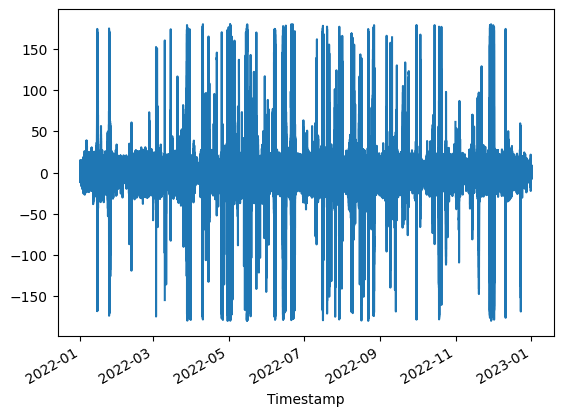

In [11]:
scada["Yaw error"].plot()

In [12]:
scada["Turbine"].unique()

array(['Kelmarsh_1', 'Kelmarsh_2', 'Kelmarsh_3', 'Kelmarsh_4',
       'Kelmarsh_5', 'Kelmarsh_6'], dtype=object)

In [ ]:
target_turbine = "Kelmarsh_4"
autoML_time_limit = 60 # 1min

for target_turbine in scada["Turbine"].unique():
    print(target_turbine)
    
    scada_clean = scada[(scada["Turbine"]!=target_turbine) | ((scada["Turbine"]==target_turbine) & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                                & (scada["Blade angle (pitch position) A (°)"]>-1.5))]

    scada_clean = scada.copy()

    scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

    scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

    scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

    X = scada_others.pivot(columns='Turbine')
    y = scada_target

    X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

    X.drop(columns=X.columns[-5:]) # remove yaw error signals, to avoid leakage (yaw error influencing the results)

    target_feature = "Power (kW)"

    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae'
    )
    predictor.fit(
        train_data=pd.concat([X.drop(columns=X.columns[-5:]),y[["Power (kW)","Yaw error"]]],axis=1), 
        time_limit=60*autoML_time_limit, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto'
    )

    target_prediction = predictor.predict(pd.concat([X.drop(columns=X.columns[-5:]),y["Yaw error"]],axis=1))

    print(np.mean(abs(y[target_feature]-target_prediction)))

    test = pd.DataFrame(columns=(pd.concat([X.drop(columns=X.columns[-5:]),y["Yaw error"]],axis=1)).columns)

    test["Yaw error"] = np.arange(-20,20,0.1)

    col_fill_data = (pd.concat([X.drop(columns=X.columns[-5:]),y["Yaw error"]],axis=1)).median().drop("Yaw error")
    for col in col_fill_data.index:
        test[col] = col_fill_data[col]

    target_prediction = predictor.predict(test)

    plt.figure()
    plt.plot(test["Yaw error"],target_prediction/target_prediction.max())
    plt.xlabel("Yaw error")
    plt.title(target_turbine)
    plt.ylim(0.6,1)
    plt.savefig(f"images/WindEurope/{target_turbine}.png")
    plt.close()


Kelmarsh_1


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250324_235302"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.50 GB / 15.94 GB (34.5%)
Disk Space Avail:   76.72 GB / 931.51 GB (8.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d

(_ray_fit pid=23024) [1000]	valid_set's l1: 57.169
(_ray_fit pid=23024) [2000]	valid_set's l1: 55.7026 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=20576) [3000]	valid_set's l1: 56.3209 [repeated 14x across cluster]
(_ray_fit pid=20576) [4000]	valid_set's l1: 55.9734 [repeated 8x across cluster]
(_ray_fit pid=22272) [5000]	valid_set's l1: 54.6902 [repeated 9x across cluster]
(_ray_fit pid=22272) [6000]	valid_set's l1: 54.5475 [repeated 8x across cluster]
(_ray_fit pid=14076) [8000]	valid_set's l1: 53.9681 [repeated 9x across cluster]
(_ray_fit pid=23024) [9000]	valid_set's l1: 54.2666 [repeated 11x across cluster]
(_ray_fit pid=22892) [10000]	valid_set's l1: 53.7197 [repeated 10x across cluster]


(_dystack pid=24432) 	-54.6136	 = Validation score   (-mean_absolute_error)
(_dystack pid=24432) 	53.66s	 = Training   runtime
(_dystack pid=24432) 	168.23s	 = Validation runtime
(_dystack pid=24432) Fitting model: LightGBM_BAG_L1 ... Training model for up to 509.41s of the 807.41s of remaining time.
(_dystack pid=24432) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.37%)


(_ray_fit pid=25388) [1000]	valid_set's l1: 55.5333 [repeated 3x across cluster]
(_ray_fit pid=12204) [2000]	valid_set's l1: 57.3093 [repeated 8x across cluster]
(_ray_fit pid=12204) [3000]	valid_set's l1: 56.8081 [repeated 8x across cluster]
(_ray_fit pid=24680) [4000]	valid_set's l1: 55.7776 [repeated 10x across cluster]
(_ray_fit pid=25388) [5000]	valid_set's l1: 54.0537 [repeated 6x across cluster]
(_ray_fit pid=24484) [6000]	valid_set's l1: 54.5738 [repeated 11x across cluster]
(_ray_fit pid=12204) [8000]	valid_set's l1: 56.4403 [repeated 7x across cluster]
(_ray_fit pid=24484) [9000]	valid_set's l1: 54.5103 [repeated 7x across cluster]


(_dystack pid=24432) 	-55.2264	 = Validation score   (-mean_absolute_error)
(_dystack pid=24432) 	52.7s	 = Training   runtime
(_dystack pid=24432) 	46.41s	 = Validation runtime
(_dystack pid=24432) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 440.72s of the 738.72s of remaining time.
(_dystack pid=24432) 	-60.322	 = Validation score   (-mean_absolute_error)
(_dystack pid=24432) 	61.99s	 = Training   runtime
(_dystack pid=24432) 	1.7s	 = Validation runtime
(_dystack pid=24432) Fitting model: CatBoost_BAG_L1 ... Training model for up to 373.83s of the 671.83s of remaining time.
(_dystack pid=24432) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.41%)
(_ray_fit pid=7892) 	Ran out of time, early stopping on iteration 7210.
(_dystack pid=24432) 	-54.5274	 = Validation score   (-mean_absolute_error)
(_dystack pid=24432) 	299.46s	 = Training   runtime
(_dystack pid=24432) 	0.4s	 = Validation 

18.854939471060703
Kelmarsh_2


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250325_005910"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       4.92 GB / 15.94 GB (30.9%)
Disk Space Avail:   72.34 GB / 931.51 GB (7.8%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d

23.5186245841805
Kelmarsh_3


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250325_020456"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.78 GB / 15.94 GB (42.6%)
Disk Space Avail:   68.06 GB / 931.51 GB (7.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d

16.124036780805927
Kelmarsh_4


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250325_031021"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       6.51 GB / 15.94 GB (40.8%)
Disk Space Avail:   63.83 GB / 931.51 GB (6.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d

19.180592790700842
Kelmarsh_5


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250325_041641"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.26 GB / 15.94 GB (33.0%)
Disk Space Avail:   59.54 GB / 931.51 GB (6.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d

18.89497257515499
Kelmarsh_6


C:\Users\Charlie\AppData\Local\Temp\ipykernel_13884\2066006457.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")
No path specified. Models will be saved in: "AutogluonModels\ag-20250325_052208"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.50 GB / 15.94 GB (34.5%)
Disk Space Avail:   55.39 GB / 931.51 GB (5.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is d